#### **Problem Statement:**
##### Context:
Financial institutions face constant threats from fraudulent transactions. Fraudsters adapt quickly, making traditional supervised detection methods less effective because they rely on labeled data that is often incomplete, delayed, or unreliable.
##### Challenge:
We need to detect suspicious transactions without relying on labels. Fraudulent activity is rare, hidden within massive volumes of legitimate transactions, and often mimics normal behavior. The system must identify anomalies in real time and adapt to evolving fraud patterns.
##### Objective:
Design and implement an unsupervised anomaly detection pipeline using clustering methods to discover unusual transaction behaviors that deviate from typical customer activity. The system should flag anomalies for further investigation by fraud analysts.


#### **Data Collection**
Retrieved data from Kaggle: https://www.kaggle.com/datasets/sriharshaeedala/financial-fraud-detection-dataset

#### **Data Loading**

In [3]:
import warnings,pandas as pd,numpy as np
warnings.filterwarnings('ignore')

In [4]:
# ~6M samples

df=pd.read_csv(r'C:\Users\rjpms\OneDrive\Documents\My learning\Machine Learning\Machine Learning models\Unsupervised\Fraud Detection\Synthetic_Financial_datasets_log.csv')

In [5]:
df['type'].value_counts(normalize=True)*100

type
CASH_OUT    35.166331
PAYMENT     33.814608
CASH_IN     21.992261
TRANSFER     8.375622
DEBIT        0.651178
Name: proportion, dtype: float64

In [6]:
# Collecting 100K samples for future inference

SAMPLE_SIZE = 100002

df_sample = (
    df
    .groupby('type', group_keys=False)
    .apply(lambda x: x.sample(
        n=int(len(x) / len(df) * SAMPLE_SIZE),
        random_state=42
    ))
    .reset_index(drop=True)
)

In [7]:
df_sample['type'].value_counts(normalize=True)*100

type
CASH_OUT    35.167
PAYMENT     33.815
CASH_IN     21.992
TRANSFER     8.375
DEBIT        0.651
Name: proportion, dtype: float64

#### **Domain Understanding**

In [8]:
df_sample.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

#### **Explanation of Features**

- **step**  
  The time unit of the transaction (each step = 1 hour). Helps track when activity occurs.

- **type**  
  The kind of transaction (CASH_IN, CASH_OUT, PAYMENT, TRANSFER, DEBIT).  
  Fraud is more common in CASH_OUT and TRANSFER.

- **amount**  
  The value of money moved in the transaction.

- **nameOrig**  
  The anonymized ID of the sender (origin account).

- **oldbalanceOrg**  
  Sender’s balance before the transaction.

- **newbalanceOrig**  
  Sender’s balance after the transaction.

- **nameDest**  
  The anonymized ID of the receiver (destination account).

- **oldbalanceDest**  
  Receiver’s balance before the transaction.

- **newbalanceDest**  
  Receiver’s balance after the transaction.
spicious.


In [9]:
df_sample.drop(['isFraud','isFlaggedFraud'],axis=1,inplace=True)

#### **Descriptive Analysis**

In [10]:
df_sample.shape

(100000, 9)

In [11]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            100000 non-null  int64  
 1   type            100000 non-null  object 
 2   amount          100000 non-null  float64
 3   nameOrig        100000 non-null  object 
 4   oldbalanceOrg   100000 non-null  float64
 5   newbalanceOrig  100000 non-null  float64
 6   nameDest        100000 non-null  object 
 7   oldbalanceDest  100000 non-null  float64
 8   newbalanceDest  100000 non-null  float64
dtypes: float64(5), int64(1), object(3)
memory usage: 6.9+ MB


In [12]:
df_sample.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
dtype: int64

In [13]:
df_sample.describe().T

,count,mean,std,min,25%,50%,75%,max
step,100000.0,2.432930e+02,1.422015e+02,1.00,156.00,239.000,3.340000e+02,7.410000e+02
amount,100000.0,1.817300e+05,6.983734e+05,0.51,13389.26,75195.240,2.086862e+05,6.015446e+07
oldbalanceOrg,100000.0,8.225156e+05,2.850277e+06,0.00,0.00,14305.000,1.074042e+05,3.479409e+07
newbalanceOrig,100000.0,8.436137e+05,2.886920e+06,0.00,0.00,0.000,1.445517e+05,3.494676e+07
oldbalanceDest,100000.0,1.118599e+06,3.746913e+06,0.00,0.00,131351.095,9.481091e+05,3.114049e+08
newbalanceDest,100000.0,1.243987e+06,4.115044e+06,0.00,0.00,215653.730,1.118422e+06,3.114929e+08


#### **Summary Statistics of Key Features (100,000 transactions)**

- **step**  
  Represents the time unit of the transaction (each step ≈ 1 hour).  
  - Median step is **239**, meaning most transactions occur around this time window.  
  - Range: from **1** up to **741**.

- **amount**  
  The value of money moved in each transaction.  
  - Median amount is about **75k**, but values range from **0.51** to **60 million**.  
  - Indicates a highly skewed distribution with a few very large transfers.

- **oldbalanceOrg**  
  Sender’s balance before the transaction.  
  - Median is only **14k**, but maximum reaches **34 million**.  
  - Many senders start with **0 balance**, showing empty accounts are common.

- **newbalanceOrig**  
  Sender’s balance after the transaction.  
  - Median is **0**, meaning many accounts are emptied after sending.  
  - Maximum again reaches **34 million**.

- **oldbalanceDest**  
  Receiver’s balance before the transaction.  
  - Median around **131k**, but some receivers start at **0**.  
  - Maximum exceeds **311 million**, showing very large accounts exist.

- **newbalanceDest**  
  Receiver’s balance after the transaction.  
  - Median about **215k**, with maximum also above **311 million**.  
  - Indicates accumulation of funds in certain destination accounts.

---
**Interpretation**:  
Most transactions are relatively small, but there are rare, very large transfers. Many senders start and end with zero balances, while some receivers accumulate extremely high balances. These skewed patterns and outliers are exactly what anomaly detection models (like Isolation Forest) can leverage to flag suspicious activity.


In [14]:
df_sample.duplicated().sum()

np.int64(0)

#### **Exploratory Data Analysis (Univariate)**

In [15]:
df_sample.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,259,CASH_IN,496707.37,C1373083589,4952451.30,5449158.67,C1340202832,987166.62,449602.71
1,201,CASH_IN,105439.58,C1205141105,79395.00,184834.58,C2035225037,977274.66,871835.08
2,326,CASH_IN,255578.06,C1228913525,9165963.42,9421541.48,C1025341440,471418.15,215840.09
3,371,CASH_IN,4122.61,C507172116,8167117.87,8171240.48,C285883107,1023353.23,1019230.62
4,10,CASH_IN,195440.90,C631715983,20530.00,215970.90,C1198620089,0.00,0.00


In [16]:
df_sample_num=df_sample.select_dtypes(include=['number'])

In [17]:
df_sample_num.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,259,496707.37,4952451.30,5449158.67,987166.62,449602.71
1,201,105439.58,79395.00,184834.58,977274.66,871835.08
2,326,255578.06,9165963.42,9421541.48,471418.15,215840.09
3,371,4122.61,8167117.87,8171240.48,1023353.23,1019230.62
4,10,195440.90,20530.00,215970.90,0.00,0.00


In [18]:
import matplotlib.pyplot as plt,seaborn as sns
%matplotlib inline

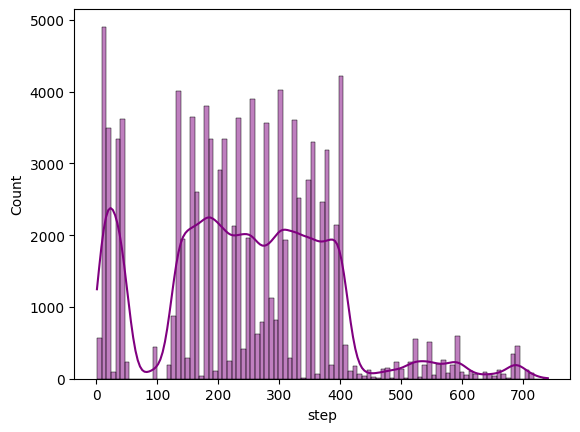

In [19]:
sns.histplot(df_sample_num['step'],kde=True,color='purple')
plt.show()

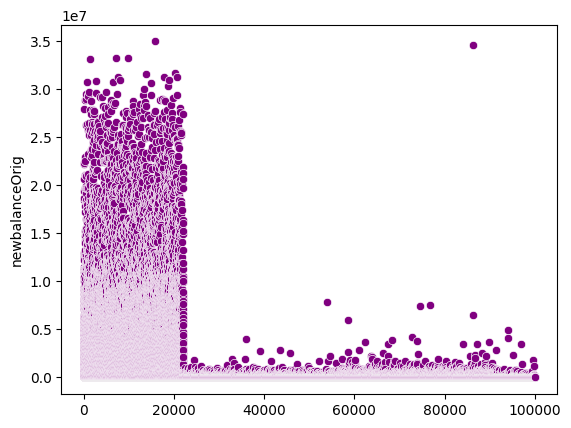

In [20]:
sns.scatterplot(df_sample_num['newbalanceOrig'],color='purple')
plt.show()

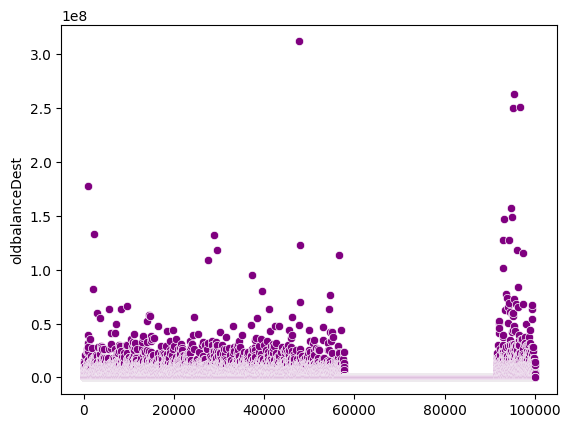

In [21]:
sns.scatterplot(df_sample_num['oldbalanceDest'],color='purple')
plt.show()

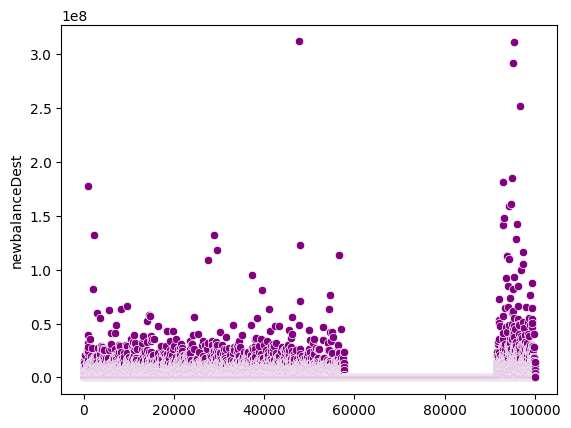

In [22]:
sns.scatterplot(df_sample_num['newbalanceDest'],color='purple')
plt.show()

In [23]:
df_sample_cat=df_sample.select_dtypes(include='object')
df_sample_cat.head()

,type,nameOrig,nameDest
0,CASH_IN,C1373083589,C1340202832
1,CASH_IN,C1205141105,C2035225037
2,CASH_IN,C1228913525,C1025341440
3,CASH_IN,C507172116,C285883107
4,CASH_IN,C631715983,C1198620089


In [24]:
df_sample_cat['type'].value_counts(normalize=True)*100

type
CASH_OUT    35.167
PAYMENT     33.815
CASH_IN     21.992
TRANSFER     8.375
DEBIT        0.651
Name: proportion, dtype: float64

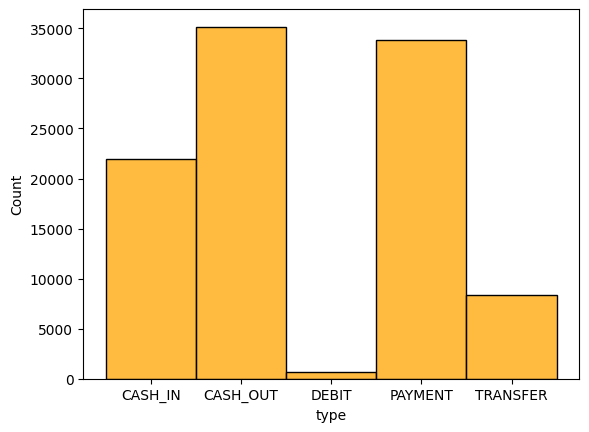

In [25]:
sns.histplot(df_sample_cat['type'],color='orange')
plt.show()

#### **BiVariate Analysis**

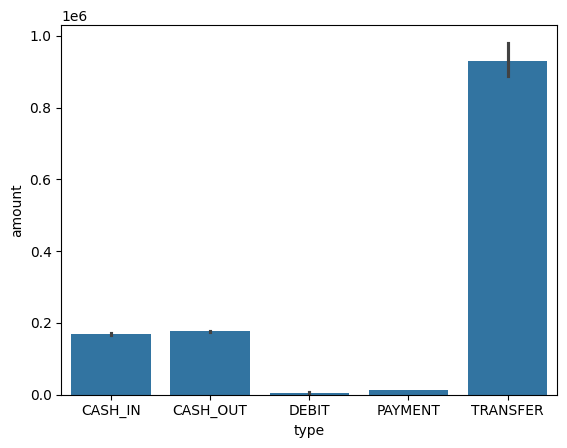

In [26]:
sns.barplot(x=df_sample_cat['type'],y=df_sample_num['amount'])
plt.show()

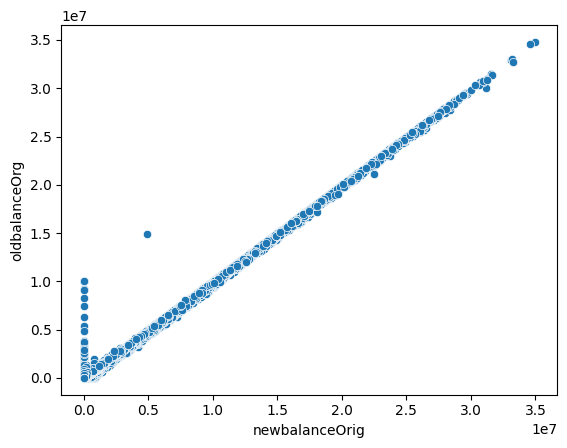

In [27]:
sns.scatterplot(x=df_sample_num['newbalanceOrig'],y=df_sample_num['oldbalanceOrg'])
plt.show()

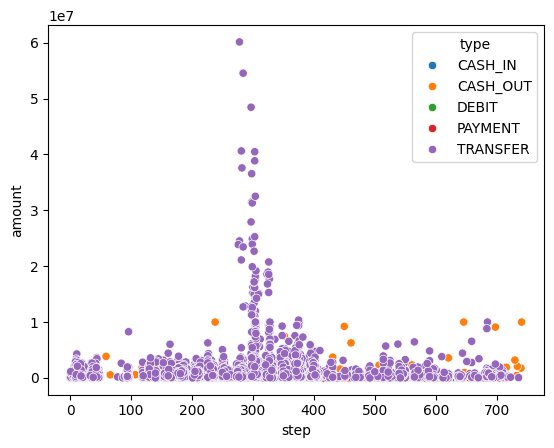

In [28]:
sns.scatterplot(x=df_sample_num['step'],y=df_sample_num['amount'],hue=df_sample_cat['type'])
plt.show()

#### **Visual Insights from Transaction Data**

- **Step Distribution**  
  Most transactions occur between steps 0–400. Activity drops sharply after step 400.

- **Transaction Type Count**  
  CASH_OUT and PAYMENT are the most frequent types. CASH_IN is moderate. TRANSFER and DEBIT are least common.

- **Transaction Amount by Type**  
  TRANSFER moves the highest total amount. CASH_IN and CASH_OUT are mid-range. PAYMENT and DEBIT involve very small amounts.

- **Amount vs Step by Type**  
  TRANSFER dominates high-value spikes around step 300. Other types show lower, scattered amounts across steps.


#### **Data Preprocessing**

##### **Encoding**

In [29]:
df_sample.head(3)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,259,CASH_IN,496707.37,C1373083589,4952451.30,5449158.67,C1340202832,987166.62,449602.71
1,201,CASH_IN,105439.58,C1205141105,79395.00,184834.58,C2035225037,977274.66,871835.08
2,326,CASH_IN,255578.06,C1228913525,9165963.42,9421541.48,C1025341440,471418.15,215840.09


In [30]:
encoded = pd.get_dummies(df_sample['type'], dtype='int') 
df_sample= pd.concat([df_sample, encoded], axis=1)

In [31]:
df_sample.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,259,CASH_IN,496707.37,C1373083589,4952451.30,5449158.67,C1340202832,987166.62,449602.71,1,0,0,0,0
1,201,CASH_IN,105439.58,C1205141105,79395.00,184834.58,C2035225037,977274.66,871835.08,1,0,0,0,0
2,326,CASH_IN,255578.06,C1228913525,9165963.42,9421541.48,C1025341440,471418.15,215840.09,1,0,0,0,0
3,371,CASH_IN,4122.61,C507172116,8167117.87,8171240.48,C285883107,1023353.23,1019230.62,1,0,0,0,0
4,10,CASH_IN,195440.90,C631715983,20530.00,215970.90,C1198620089,0.00,0.00,1,0,0,0,0


#### **Feature Engineering**

In [32]:
df_sample.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,259,CASH_IN,496707.37,C1373083589,4952451.30,5449158.67,C1340202832,987166.62,449602.71,1,0,0,0,0
1,201,CASH_IN,105439.58,C1205141105,79395.00,184834.58,C2035225037,977274.66,871835.08,1,0,0,0,0
2,326,CASH_IN,255578.06,C1228913525,9165963.42,9421541.48,C1025341440,471418.15,215840.09,1,0,0,0,0
3,371,CASH_IN,4122.61,C507172116,8167117.87,8171240.48,C285883107,1023353.23,1019230.62,1,0,0,0,0
4,10,CASH_IN,195440.90,C631715983,20530.00,215970.90,C1198620089,0.00,0.00,1,0,0,0,0


In [33]:
df_sample['amount_to_oldbalanceOrg_ratio']=df_sample['amount']/(df_sample['oldbalanceOrg']+1)

In [34]:
df_sample['sender_balance_diff'] = np.where(
    (df_sample['CASH_OUT'] == 1) | (df_sample['TRANSFER'] == 1),
    df_sample['oldbalanceOrg'] - df_sample['newbalanceOrig'],
    0
)

In [35]:
sender_receiver_freq = df.groupby(['nameOrig','nameDest']).size().reset_index(name='sender_receiver_count')
df_sample = df_sample.merge(sender_receiver_freq, on=['nameOrig','nameDest'], how='left')
df_sample['sender_receiver_count'] = df_sample['sender_receiver_count'].fillna(0)

In [36]:
df_sample['is_new_receiver'] = (df_sample['sender_receiver_count'] == 1).astype(int)

In [37]:
df_sample['is_new_receiver'].value_counts()

is_new_receiver
1    100000
Name: count, dtype: int64

In [38]:
sender_avg_amount = df.groupby('nameOrig')['amount'].mean().reset_index(name='sender_avg_amount')
df_sample = df_sample.merge(sender_avg_amount, on='nameOrig', how='left')
df_sample['amount_to_avg_ratio'] = df_sample['amount'] / (df_sample['sender_avg_amount'] + 1) 

In [39]:
df_sample['amount_pct_sender_balance'] = df_sample['amount'] / (df_sample['oldbalanceOrg'] + 1)  

In [40]:
df['is_high_risk_type'] = df['type'].isin(['CASH_OUT', 'TRANSFER']).astype(int)
sender_risk_ratio = (
    df.groupby('nameOrig')['is_high_risk_type']
      .mean()
      .reset_index(name='high_risk_ratio')
)
df_risky = df[df['type'].isin(['CASH_OUT', 'TRANSFER'])].copy()
df_sample = df_sample.merge(sender_risk_ratio, on='nameOrig', how='left')
df_sample['high_risk_ratio'] = df_sample['high_risk_ratio'].fillna(0)
df_sample = df_sample.drop(columns=['PAYMENT', 'DEBIT', 'CASH_IN'], errors='ignore')

#### **Engineered Features Explained**

- **amount_to_oldbalanceOrg_ratio**  
  Ratio of transaction amount to the sender’s old balance.  
  → Highlights cases where nearly all funds are transferred.

- **sender_balance_diff**  
  Difference between old and new balance of the sender.  
  → Normally equals the transaction amount; deviations may signal fraud.

- **sender_receiver_count**  
  Number of unique receivers a sender has transacted with.  
  → Fraudsters often interact with many different accounts.

- **is_new_receiver**  
  Flag showing if the receiver is new for this sender.  
  → Sending to unseen accounts can be suspicious.

- **sender_avg_amount**  
  Average transaction amount for this sender.  
  → Provides a baseline for typical behavior.

- **amount_to_avg_ratio**  
  Current transaction amount divided by sender’s average amount.  
  → Large deviations from normal behavior may indicate anomalies.

- **amount_pct_sender_balance**  
  Percentage of sender’s balance used in this transaction.  
  → Very high percentages (close to 100%) are risky.

- **high_risk_ratio**  
  Ratio of high‑risk transaction types (CASH_OUT + TRANSFER) to total transactions for a sender.  
  → Fraudsters often have a higher proportion of risky transaction types.


#### **Model Training**

In [41]:
df_sample.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,CASH_OUT,TRANSFER,amount_to_oldbalanceOrg_ratio,sender_balance_diff,sender_receiver_count,is_new_receiver,sender_avg_amount,amount_to_avg_ratio,amount_pct_sender_balance,high_risk_ratio
0,259,CASH_IN,496707.37,C1373083589,4952451.30,5449158.67,C1340202832,987166.62,449602.71,0,0,0.100295,0.0,1,1,496707.37,0.999998,0.100295,0.0
1,201,CASH_IN,105439.58,C1205141105,79395.00,184834.58,C2035225037,977274.66,871835.08,0,0,1.328021,0.0,1,1,105439.58,0.999991,1.328021,0.0
2,326,CASH_IN,255578.06,C1228913525,9165963.42,9421541.48,C1025341440,471418.15,215840.09,0,0,0.027883,0.0,1,1,255578.06,0.999996,0.027883,0.0
3,371,CASH_IN,4122.61,C507172116,8167117.87,8171240.48,C285883107,1023353.23,1019230.62,0,0,0.000505,0.0,1,1,4122.61,0.999757,0.000505,0.0
4,10,CASH_IN,195440.90,C631715983,20530.00,215970.90,C1198620089,0.00,0.00,0,0,9.519307,0.0,1,1,195440.90,0.999995,9.519307,0.0


In [42]:
df_sample['high_risk_ratio'].value_counts(normalize=True)*100

high_risk_ratio
0.000000    56.384
1.000000    43.468
0.500000     0.147
0.333333     0.001
Name: proportion, dtype: float64

In [43]:
from sklearn.ensemble import IsolationForest #Best for anomaly detection

In [44]:
iso=IsolationForest(n_estimators=300,n_jobs=-1,contamination=0.01,random_state=7)
iso.get_params()

{'bootstrap': False,
 'contamination': 0.01,
 'max_features': 1.0,
 'max_samples': 'auto',
 'n_estimators': 300,
 'n_jobs': -1,
 'random_state': 7,
 'verbose': 0,
 'warm_start': False}

In [45]:
features=['amount_to_oldbalanceOrg_ratio',
          'sender_balance_diff',
          'sender_receiver_count',
          'is_new_receiver',
          'sender_avg_amount',
          'amount_to_avg_ratio',
          'amount_pct_sender_balance',
          'high_risk_ratio']

In [46]:
Xtrain=df_sample[features]
%time iso.fit(Xtrain)

CPU times: total: 1.75 s
Wall time: 1.58 s


IsolationForest(contamination=0.01, n_estimators=300, n_jobs=-1, random_state=7)

In [47]:
df_sample['risk_score_raw'] = iso.decision_function(Xtrain)

In [48]:
df_sample['risk_score'] = 1 - ((df_sample['risk_score_raw'] - df_sample['risk_score_raw'].min()) /
                         (df_sample['risk_score_raw'].max() - df_sample['risk_score_raw'].min()))

def risk_category(score):
    if score >= 0.9:
        return "Critical"
    elif score >= 0.7:
        return "Suspicious"
    elif score >= 0.4:
        return "Monitor"
    else:
        return "Normal"

df_sample['risk_category'] = df_sample['risk_score'].apply(risk_category)

In [49]:
df_sample['risk_category'].value_counts()

risk_category
Normal        95746
Monitor        3363
Suspicious      673
Critical        218
Name: count, dtype: int64

In [50]:
df_sample.sort_values('risk_score',ascending=True).head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,CASH_OUT,...,sender_balance_diff,sender_receiver_count,is_new_receiver,sender_avg_amount,amount_to_avg_ratio,amount_pct_sender_balance,high_risk_ratio,risk_score_raw,risk_score,risk_category
80750,403,PAYMENT,19591.77,C831578991,699838.00,680246.23,M225463381,0.00,0.00,0,...,0.0,1,1,19591.77,0.999949,0.027995,0.0,0.333368,0.0,Normal
80895,356,PAYMENT,19749.78,C961601529,122349.75,102599.98,M603640030,0.00,0.00,0,...,0.0,1,1,19749.78,0.999949,0.161419,0.0,0.333368,0.0,Normal
61510,161,PAYMENT,19321.80,C951990440,298648.82,279327.02,M1357110926,0.00,0.00,0,...,0.0,1,1,19321.80,0.999948,0.064697,0.0,0.333368,0.0,Normal
21689,260,CASH_IN,19448.54,C1953698229,1268750.83,1288199.37,C2047725871,22523.32,3074.79,0,...,0.0,1,1,19448.54,0.999949,0.015329,0.0,0.333368,0.0,Normal
21346,478,CASH_IN,19135.90,C826209725,2704865.03,2724000.93,C424671456,3054811.29,3035675.39,0,...,0.0,1,1,19135.90,0.999948,0.007075,0.0,0.333368,0.0,Normal
74491,252,PAYMENT,19751.94,C1501220650,219762.00,200010.06,M819941705,0.00,0.00,0,...,0.0,1,1,19751.94,0.999949,0.089878,0.0,0.333368,0.0,Normal
87311,353,PAYMENT,19676.83,C636764766,336899.43,317222.60,M11410426,0.00,0.00,0,...,0.0,1,1,19676.83,0.999949,0.058405,0.0,0.333368,0.0,Normal
83595,19,PAYMENT,19191.80,C479912065,667399.67,648207.87,M1514612815,0.00,0.00,0,...,0.0,1,1,19191.80,0.999948,0.028756,0.0,0.333368,0.0,Normal
60765,157,PAYMENT,19512.69,C1522106355,261500.02,241987.33,M1134244683,0.00,0.00,0,...,0.0,1,1,19512.69,0.999949,0.074618,0.0,0.333368,0.0,Normal
91248,154,PAYMENT,19551.33,C1510783980,262907.07,243355.73,M2093149876,0.00,0.00,0,...,0.0,1,1,19551.33,0.999949,0.074366,0.0,0.333368,0.0,Normal


In [51]:
import joblib
joblib.dump(iso, 'iso_forest_model.pkl')
joblib.dump({'min': df_sample['risk_score_raw'].min(), 'max': df_sample['risk_score_raw'].max()}, 'risk_score_norm.pkl')
df_sample.to_csv('df_sample_scored.csv', index=False)

In [52]:
print(4)

4


In [53]:
import joblib
%time iso = joblib.load("iso_forest_model.pkl")
%time norm = joblib.load("risk_score_norm.pkl")

CPU times: total: 31.2 ms
Wall time: 51.1 ms
CPU times: total: 0 ns
Wall time: 18.9 ms
